In [1]:
import numpy as np
import tensorflow as tf
from scipy.interpolate import CubicSpline

2024-09-20 12:19:39.369084: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 12:19:39.370593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 12:19:39.397154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 12:19:39.397203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 12:19:39.397228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
class NaturalCubicSpline(tf.keras.layers.Layer):
    def __init__(self, x, y=None, **kwargs):
        """
        Initialize with x (data points) and y (TensorFlow Variables).
        x: 1D numpy array of shape (n,) for the interpolation points
        y: TensorFlow variable of shape (n,) for the values at the interpolation points
        """
        super().__init__(**kwargs)
        assert np.all(np.diff(x) > 0.0)
        # NOTE: To make the x trainable we would need to also enforce their ordering somehow
        self.x = self.add_weight(
            shape=x.shape,
            name="x",
            trainable=False,
            initializer=tf.constant_initializer(x),
        )
        self.y = self.add_weight(
            shape=x.shape,
            name="y",
            trainable=True,
            initializer=tf.zeros_initializer()
            if y is None
            else tf.constant_initializer(y),
        )
        self.n = len(x)

        # Compute the distances between the x points (h_i = x_{i+1} - x_i)
        # NOTE: no equivalent for np.diff in tensorflow
        self.h = self.x[1:] - self.x[:-1]

    def compute_coefficients(self):
        """
        Compute the coefficients of the natural cubic spline.
        """
        # Compute the matrix system to solve for the second derivatives
        A = self._construct_tridiagonal_matrix()
        b = self._construct_rhs()

        # Solve for the second derivatives (M)
        # TODO refactor to use diagonals_format = compact
        M = tf.linalg.tridiagonal_solve(A, b, diagonals_format="matrix")

        return M

    def _construct_tridiagonal_matrix(self):
        """
        Construct the tridiagonal matrix for the natural cubic spline system.
        """

        return (
            tf.linalg.diag(
                tf.concat(
                    [tf.ones((1,)), 2 * (self.h[:-1] + self.h[1:]), tf.ones((1,))],
                    axis=0,
                )
            )
            + tf.linalg.diag(tf.concat([tf.zeros((1,)), self.h[1:]], axis=0), k=1)
            + tf.linalg.diag(tf.concat([self.h[:-1], tf.zeros((1,))], axis=0), k=-1)
        )

    def _construct_rhs(self):
        """
        Construct the right-hand side vector b for the natural cubic spline system.
        """
        y = self.y
        h = self.h
        b = tf.concat(
            [
                tf.zeros((1,)),
                6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1]),
                tf.zeros((1,)),
            ],
            axis=0,
        )

        return b

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=(None, 1), dtype=tf.keras.backend.floatx()),
        )
    )
    def call(self, x_new):
        """
        Evaluate the spline values at r points using the coefficients.
        """
        x_new = tf.squeeze(x_new)
        M = self.compute_coefficients()

        # Find the interval where each x_new belongs
        idx = tf.searchsorted(self.x, x_new) - 1
        # To enable extrapolation use the edge polynomials whenever
        # the index is < 0 or > n - 1.
        idx = tf.clip_by_value(idx, 0, self.n - 2)

        # Get corresponding h values for each x_new
        h = tf.gather(self.h, idx)

        # Compute spline components
        a = (tf.gather(self.x, idx + 1) - x_new) / h
        b = (x_new - tf.gather(self.x, idx)) / h

        # Compute spline value using the natural cubic spline formula
        spline_value = (
            a * tf.gather(self.y, idx)
            + b * tf.gather(self.y, idx + 1)
            + ((a**3 - a) * tf.gather(M, idx) + (b**3 - b) * tf.gather(M, idx + 1))
            * (h**2)
            / 6
        )

        return tf.reshape(spline_value, (-1, 1))


In [3]:
class ClampedCubicSpline(NaturalCubicSpline):
    def __init__(self, x, y=None, dy=[0, 0], dy_trainable=True, **kwargs):
        """
        Initialize with x (data points) and y (TensorFlow Variables).
        x: 1D numpy array of shape (n,) for the interpolation points
        y: TensorFlow variable of shape (n,) for the values at the interpolation points
        """
        super().__init__(x, y=y, **kwargs)
        self.dy = self.add_weight(
            shape=(2,),
            name="dy",
            trainable=dy_trainable,
            initializer=tf.zeros_initializer()
            if dy is None
            else tf.constant_initializer(dy),
        )

    def _construct_tridiagonal_matrix(self):
        """
        Construct the tridiagonal matrix for the natural cubic spline system.
        """
        return (
            tf.linalg.diag(
                tf.concat(
                    [2 * self.h[:1], 2 * (self.h[:-1] + self.h[1:]), 2 * self.h[-1:]],
                    axis=0,
                )
            )
            + tf.linalg.diag(self.h, k=1)
            + tf.linalg.diag(self.h, k=-1)
        )

    def _construct_rhs(self):
        """
        Construct the right-hand side vector b for the natural cubic spline system.
        """
        y = self.y
        h = self.h
        b = tf.concat(
            [
                6 * ((y[1] - y[0]) / h[0] - self.dy[:1]),
                6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1]),
                6 * (self.dy[-1:] - (y[-1] - y[-2]) / h[-1]),
            ],
            axis=0,
        )

        return b

In [4]:
class FittedCubicSpline(tf.keras.layers.Layer):
    def __init__(self, x, y=None, dy=None, **kwargs):
        """
        Initialize with x (data points) and y (TensorFlow Variables).
        x: 1D numpy array of shape (n,) for the interpolation points
        y: TensorFlow variable of shape (n,) for the values at the interpolation points
        """
        super().__init__(**kwargs)
        assert np.all(np.diff(x) > 0.0)
        # NOTE: To make the x trainable we would need to also enforce their ordering somehow
        self.x = self.add_weight(
            shape=x.shape,
            name="x",
            trainable=False,
            initializer=tf.constant_initializer(x),
        )
        self.y = self.add_weight(
            shape=x.shape,
            name="y",
            trainable=True,
            initializer=tf.zeros_initializer()
            if y is None
            else tf.constant_initializer(y),
        )
        self.dy = self.add_weight(
            shape=x.shape,
            name="dy",
            trainable=True,
            initializer=tf.zeros_initializer()
            if dy is None
            else tf.constant_initializer(dy),
        )
        self.n = len(x)

        # Compute the distances between the x points (h_i = x_{i+1} - x_i)
        # NOTE: no equivalent for np.diff in tensorflow
        self.h = self.x[1:] - self.x[:-1]

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=(None, 1), dtype=tf.keras.backend.floatx()),
        )
    )
    def call(self, x_new):
        """
        Evaluate the spline values at r points using the coefficients.
        """
        x_new = tf.squeeze(x_new)

        # Find the interval where each x_new belongs
        idx = tf.searchsorted(self.x, x_new) - 1
        # To enable extrapolation use the edge polynomials whenever
        # the index is < 0 or > n - 1.
        idx = tf.clip_by_value(idx, 0, self.n - 2)

        # Get corresponding h values for each x_new
        h = tf.gather(self.h, idx)

        # Compute spline components
        t = (x_new - tf.gather(self.x, idx)) / h

        y_left = tf.gather(self.y, idx)
        y_right = tf.gather(self.y, idx + 1)
        dy_left = tf.gather(self.dy, idx)
        dy_right = tf.gather(self.dy, idx + 1)

        # Compute spline value using the natural cubic spline formula
        spline_value = (
            (2 * t**3 - 3 * t**2 + 1) * y_left
            + (t**3 - 2 * t**2 + t) * h * dy_left
            + (-2 * t**3 + 3 * t**2) * y_right
            + (t**3 - t**2) * h * dy_right
        )

        return tf.reshape(spline_value, (-1, 1))


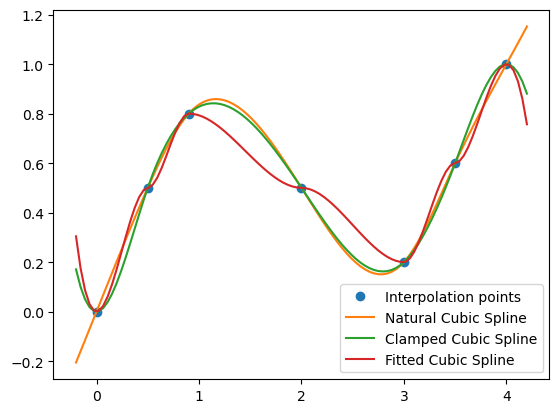

In [5]:
# Define x (interpolation points) and y (adjustable y-values)
x = np.array([0.0, 0.5, 0.9, 2.0, 3.0, 3.5, 4.0])

# Initialize y
y = np.array([0.0, 0.5, 0.8, 0.5, 0.2, 0.6, 1.0])[: len(x)]

# Create an instance of the NaturalCubicSpline
spline = NaturalCubicSpline(x, y)
spline_clamped = ClampedCubicSpline(x, y)
spline_fitted = FittedCubicSpline(x, y=y)

# Define new x points where you want to evaluate the spline
x_fit = np.linspace(-0.1, 4.1, 100).reshape(-1, 1)
# x_fit = x.reshape(-1, 1)

# Print or plot the results
import matplotlib.pyplot as plt

x_plot = np.linspace(-0.2, 4.2, 101).reshape(-1, 1)

plt.plot(x, spline.y.numpy(), "o", label="Interpolation points")
plt.plot(x_plot, spline(x_plot), label="Natural Cubic Spline")
plt.plot(x_plot, spline_clamped(x_plot), label="Clamped Cubic Spline")
plt.plot(x_plot, spline_fitted(x_plot), label="Fitted Cubic Spline")
plt.legend()


In [6]:
# Define a loss function (for example, a mean squared error against some target values)
# Target curve (just an example)
def target_fun(x):
    return np.sinc(x)


target_y = target_fun(x_fit)

for model in [spline, spline_clamped, spline_fitted]:
    # Loss: Mean squared error between the spline values and the target curve
    def loss_fn():
        return tf.reduce_mean(tf.square(model(x_fit) - target_y))

    # Use an optimizer to minimize the loss and adjust the y-values
    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    # Training loop
    for step in range(1000):
        optimizer.minimize(loss_fn, var_list=[w for w in model.weights if w.trainable])

        if step % 200 == 0:
            print(f"Step {step}: Loss = {loss_fn().numpy()}")

    # After training, the y-values should be adjusted
    print("Adjusted weights:")
    for w in model.weights:
        if w.trainable:
            print(w.name, w.numpy())


Step 0: Loss = 0.4434998035430908
Step 200: Loss = 0.0006041081505827606
Step 400: Loss = 0.000528187898453325
Step 600: Loss = 0.0005281878402456641
Step 800: Loss = 0.0005281878402456641
Adjusted weights:
y:0 [ 9.9161816e-01  6.7098790e-01  7.0248567e-02 -5.5014889e-04
  3.1133676e-02 -1.0675673e-01  8.6572403e-03]
Step 0: Loss = 0.4465327858924866
Step 200: Loss = 0.000686099985614419
Step 400: Loss = 0.0004591442702803761
Step 600: Loss = 0.0004547930439002812
Step 800: Loss = 0.00045476204832084477
Adjusted weights:
y:0 [ 0.99192274  0.6645955   0.07003924 -0.00419148  0.03152311 -0.11374205
  0.0076774 ]
dy:0 [-0.16208228  0.10409917]
Step 0: Loss = 0.40313729643821716
Step 200: Loss = 0.0006501361494883895
Step 400: Loss = 0.00017644050240051
Step 600: Loss = 7.597918738611042e-05
Step 800: Loss = 3.333108907099813e-05
Adjusted weights:
y:0 [ 1.0022093e+00  6.3722348e-01  1.0245125e-01 -1.2311828e-03
  7.6479232e-04 -9.1009021e-02 -1.3215079e-04]
dy:0 [ 0.01273356 -1.2439531  -1

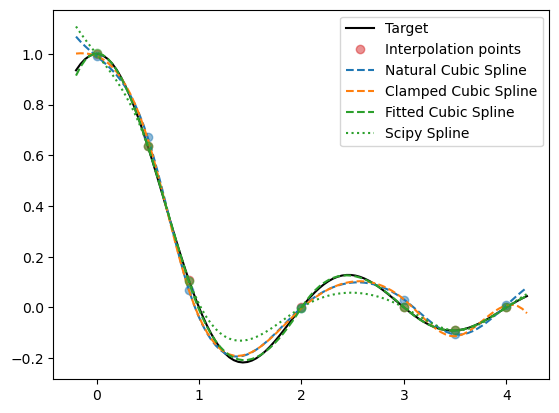

In [7]:
plt.plot(x_plot, target_fun(x_plot), "k", label="Target")
plt.plot(
    x,
    target_fun(x),
    "C3o",
    label="Interpolation points",
    alpha=0.5,
)

scipy_spline = CubicSpline(x, target_fun(x), bc_type="natural")
plt.plot(x_plot, spline(x_plot), "C0--", label="Natural Cubic Spline")
plt.plot(spline.x, spline(spline.x.numpy().reshape(-1, 1)), "C0o", alpha=0.5)
plt.plot(x_plot, spline_clamped(x_plot), "C1--", label="Clamped Cubic Spline")
plt.plot(x_plot, spline_fitted(x_plot), "C2--", label="Fitted Cubic Spline")
plt.plot(
    spline_fitted.x,
    spline_fitted(spline_fitted.x.numpy().reshape(-1, 1)),
    "C2o",
    alpha=0.5,
)
plt.plot(x_plot, scipy_spline(x_plot), "C32:", label="Scipy Spline")
plt.legend()
# plt.yscale("log")
# plt.xlim(2.99, 3.01)
# plt.ylim(-0.1, 0.1)

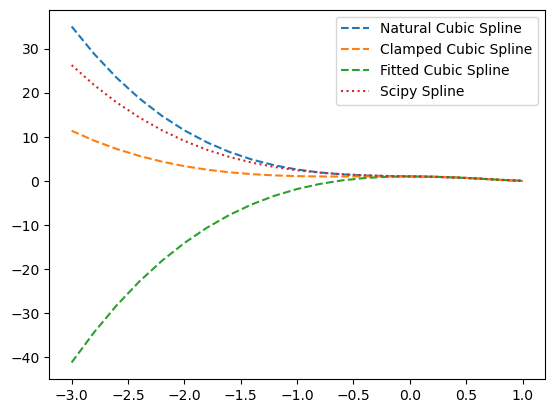

In [8]:
# Difference is because the TF implementation actually tries to fit the full range
# of x_new
x_extrap = np.linspace(-3, 1, 21).reshape(-1, 1)
plt.plot(x_extrap, spline(x_extrap), "--", label="Natural Cubic Spline")
plt.plot(x_extrap, spline_clamped(x_extrap), "--", label="Clamped Cubic Spline")
plt.plot(x_extrap, spline_fitted(x_extrap), "--", label="Fitted Cubic Spline")
plt.plot(x_extrap, scipy_spline(x_extrap), ":", label="Scipy Spline")
plt.legend()